In [1]:
import xgboost as xgb
from xgboost import XGBClassifier
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import sklearn
sklearn.set_config(transform_output="pandas")
import category_encoders as ce
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate

In [2]:
df = pd.read_csv('./data/final_script.csv')
df = df.loc[:,~df.columns.str.startswith('Unnamed')]
df.head(5)

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,...,sim1_legal_question_score,sim1_conclusion_score,sim2_facts_score,sim2_issue_area_score,sim1_facts_href,sim2_facts_href,sim1_issue_area_href,sim2_issue_area_href,sim1_legal_question_href,sim1_conclusion_href
0,53057,City of Oklahoma City v. Tuttle,https://api.oyez.org/cases/1984/83-1919,83-1919,1984,City of Oklahoma City,"Rose Marie Tuttle, Individually and as Adminis...","<p>On October 10, 1980, an Oklahoma City polic...",952,7,...,0.882680,0.910945,0.880510,1.0,https://api.oyez.org/cases/1997/96-957,https://api.oyez.org/cases/2013/13-551,https://api.oyez.org/cases/1960/32,https://api.oyez.org/cases/1972/71-1336,https://api.oyez.org/cases/2016/16-369,https://api.oyez.org/cases/1997/96-827
1,55708,City of Ontario v. Quon,https://api.oyez.org/cases/2009/08-1332,08-1332,2009,"City of Ontario, California et al.","Jeff Quon, et al.","<p>Employees of the City of Ontario, Californi...",1494,9,...,0.889324,0.910785,0.877608,1.0,https://api.oyez.org/cases/2004/03-710,https://api.oyez.org/cases/1988/87-6571,https://api.oyez.org/cases/2011/10-637,https://api.oyez.org/cases/1999/98-1036,https://api.oyez.org/cases/1988/87-764,https://api.oyez.org/cases/2011/10-1259
2,51555,City of Philadelphia v. New Jersey,https://api.oyez.org/cases/1976/75-1150,75-1150,1976,City of Philadelphia et al.,New Jersey et al.,<p>A New Jersey statute prohibited the importa...,430,5,...,0.913905,0.892045,0.865124,1.0,https://api.oyez.org/cases/1977/77-404,https://api.oyez.org/cases/1940-1955/330us1,https://api.oyez.org/cases/2007/06-666,https://api.oyez.org/cases/1976/75-978,https://api.oyez.org/cases/1977/77-404,https://api.oyez.org/cases/1978/77-154
3,51844,City of Philadelphia v. New Jersey,https://api.oyez.org/cases/1977/77-404,77-404,1977,City of Philadelphia,New Jersey,<p>A New Jersey law prohibited the importation...,162,7,...,0.917768,0.910676,0.863157,1.0,https://api.oyez.org/cases/1976/75-1150,https://api.oyez.org/cases/1993/93-70,https://api.oyez.org/cases/2007/06-666,https://api.oyez.org/cases/1976/75-978,https://api.oyez.org/cases/1993/93-70,https://api.oyez.org/cases/1993/93-70
4,55235,City of Rancho Palos Verdes v. Abrams,https://api.oyez.org/cases/2004/03-1601,03-1601,2004,"City of Rancho Palos Verdes, California, et al.",Mark J. Abrams,"<p>Rancho Palos Verdes, a city in California, ...",1094,9,...,0.843087,0.828414,0.884123,1.0,https://api.oyez.org/cases/2003/02-1238,https://api.oyez.org/cases/2014/13-975,https://api.oyez.org/cases/1960/32,https://api.oyez.org/cases/1972/71-1336,https://api.oyez.org/cases/1999/98-791,https://api.oyez.org/cases/1940-1955/341us494


In [3]:
df['issue_area'].unique()
df.groupby('issue_area').size()

drop_issue_area = ['interstate relations', 'majority opinion', 'private action']
# df['issue_area'].value_counts().plot(kind='bar')
df = df[~df['issue_area'].isin(drop_issue_area)]
df.groupby('issue_area').size()

issue_area
attorneys              32
civil rights          469
criminal procedure    709
due process           102
economic activity     439
federal taxation       45
federalism             96
first amendment       290
judicial power        274
miscellaneous          19
privacy                59
unions                 46
dtype: int64

In [4]:
df['fpw'] = df['first_party_winner'].map({'True': 1,'False' :0 })
min_df = df[['href', 'fpw', 'issue_area']]
sim1_facts_df = pd.merge(df, min_df, how="left", suffixes=(None, '_sim1_facts'), left_on='sim1_facts_href', right_on='href')
sim2_facts_df = pd.merge(sim1_facts_df, min_df, how="left", suffixes=(None, '_sim2_facts'), left_on='sim2_facts_href', right_on='href')

sim1_issue_area_df = pd.merge(sim2_facts_df, min_df, how="left", suffixes=(None, '_sim1_issue_area'), left_on='sim1_issue_area_href', right_on='href')
sim2_issue_area_df = pd.merge(sim1_issue_area_df, min_df, how="left", suffixes=(None, '_sim2_issue_area'), left_on='sim2_issue_area_href', right_on='href')

sim1_legal_question_df = pd.merge(sim2_issue_area_df, min_df, how="left", suffixes=(None, '_sim1_legal_question'), left_on='sim1_legal_question_href', right_on='href')

sim1_conclusion_df = pd.merge(sim1_legal_question_df, min_df, how="left", suffixes=(None, '_sim1_conclusion'), left_on='sim1_conclusion_href', right_on='href')

merged_df = sim1_conclusion_df
merged_df['fpw'] = merged_df[merged_df['fpw'].notna()]['fpw'].astype(int)
merged_df = merged_df[merged_df['issue_area'].notna()]

In [5]:
print(list(merged_df.filter(regex='issue_area')))

['issue_area', 'sim1_issue_area_score', 'sim2_issue_area_score', 'sim1_issue_area_href', 'sim2_issue_area_href', 'issue_area_sim1_facts', 'issue_area_sim2_facts', 'href_sim1_issue_area', 'fpw_sim1_issue_area', 'issue_area_sim1_issue_area', 'href_sim2_issue_area', 'fpw_sim2_issue_area', 'issue_area_sim2_issue_area', 'issue_area_sim1_legal_question', 'issue_area_sim1_conclusion']


In [6]:
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='Unnamed')))]
# merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='_issue_area')))]
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='^issue_area_')))]
merged_df = merged_df[merged_df.columns.drop(list(merged_df.filter(regex='href')))]
merged_df = merged_df[merged_df['term'].str.isnumeric()]
merged_df = merged_df.drop('ID', axis=1)
merged_df = merged_df.drop('name', axis=1)
merged_df = merged_df.drop('docket', axis=1)
merged_df = merged_df.drop('facts', axis=1)
merged_df = merged_df.drop('facts_len', axis=1)
merged_df = merged_df.drop('majority_vote', axis=1)
merged_df = merged_df.drop('minority_vote', axis=1)
merged_df = merged_df.drop('disposition', axis=1)
merged_df = merged_df.drop('decision_type', axis=1)
merged_df = merged_df.drop('first_party_winner', axis=1)
merged_df = merged_df.drop('legal_question', axis=1)
merged_df = merged_df.drop('facts_clean', axis=1)
merged_df = merged_df.drop('conclusion', axis=1)
# merged_df = merged_df.drop('issue_area_sim2_issue_area', axis=1)
# merged_df = merged_df.drop('issue_area_sim1_issue_area', axis=1)
merged_df['term'] = merged_df['term'].astype('float')

merged_df.columns
print(list(merged_df.filter(regex='issue_area')))


['issue_area', 'sim1_issue_area_score', 'sim2_issue_area_score', 'fpw_sim1_issue_area', 'fpw_sim2_issue_area']


In [7]:
cat_vars = ['first_party',
            'second_party',
            'issue_area',
            'first_party_entity',
            'second_party_entity',
            'judges',
            'lower_court']
for col in cat_vars:
    merged_df[col] = merged_df[col].astype('category')

In [8]:
merged_df.to_csv('for_training.csv')

<Axes: >

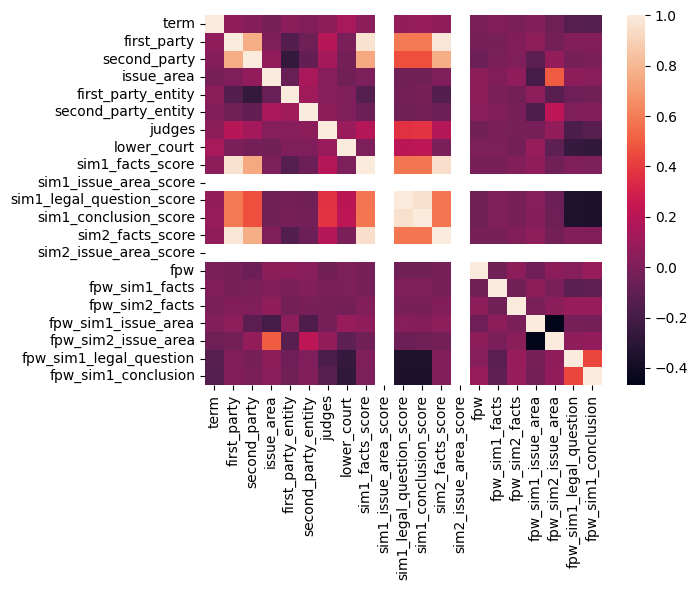

In [9]:
corr = merged_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr)

In [10]:
# corr_matrix = merged_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
merged_df.drop(to_drop, axis=1, inplace=True)

In [11]:
list(merged_df.columns)

['term',
 'first_party',
 'second_party',
 'issue_area',
 'first_party_entity',
 'second_party_entity',
 'judges',
 'lower_court',
 'sim1_issue_area_score',
 'sim1_legal_question_score',
 'sim2_issue_area_score',
 'fpw',
 'fpw_sim1_facts',
 'fpw_sim2_facts',
 'fpw_sim1_issue_area',
 'fpw_sim2_issue_area',
 'fpw_sim1_legal_question',
 'fpw_sim1_conclusion']

In [12]:
# encoded_df = pd.get_dummies(merged_df, columns=['issue_area', ], dtype=int)
# y = encoded_df[encoded_df.columns[-12:]]
# X = encoded_df.drop(columns=encoded_df.columns[:-12], axis=1, inplace=True)
y = merged_df['issue_area']
X = merged_df.drop(columns='issue_area')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [13]:


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)
# print(y_train_enc)
# print(X_train)
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model = XGBClassifier(objective='multi:softprob', enable_categorical=True, num_class=12)
model.fit(X_train, y_train_enc)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=12,
              num_parallel_tree=None, ...)

In [14]:
# encoded_df = pd.get_dummies(y, columns=['issue_area', ], dtype=int)

In [16]:


def fit_and_score(estimator, X_train, X_test, y_train, y_test):
    """Fit the estimator on the train set and score it on both sets"""
    estimator.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)

    return estimator, train_score, test_score

results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=94)

for train, test in cv.split(X, y):
    # print(train)
    # print(test)
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    est, train_score, test_score = fit_and_score(
        clone(model), X_train, X_test, y_train_enc, y_test_enc
    )
    results[est] = (train_score, test_score)

[0]	validation_0-mlogloss:2.35193
[1]	validation_0-mlogloss:2.28137
[2]	validation_0-mlogloss:2.22957
[3]	validation_0-mlogloss:2.19574
[4]	validation_0-mlogloss:2.17506
[5]	validation_0-mlogloss:2.16323
[6]	validation_0-mlogloss:2.15538
[7]	validation_0-mlogloss:2.14983
[8]	validation_0-mlogloss:2.14716
[9]	validation_0-mlogloss:2.14625
[10]	validation_0-mlogloss:2.14682
[11]	validation_0-mlogloss:2.14891
[12]	validation_0-mlogloss:2.15639
[13]	validation_0-mlogloss:2.16786
[14]	validation_0-mlogloss:2.17410
[15]	validation_0-mlogloss:2.17920
[16]	validation_0-mlogloss:2.18493
[17]	validation_0-mlogloss:2.19918
[18]	validation_0-mlogloss:2.20721
[19]	validation_0-mlogloss:2.21491
[20]	validation_0-mlogloss:2.22638
[21]	validation_0-mlogloss:2.23625
[22]	validation_0-mlogloss:2.24392
[23]	validation_0-mlogloss:2.25426
[24]	validation_0-mlogloss:2.26400
[25]	validation_0-mlogloss:2.27246
[26]	validation_0-mlogloss:2.28590
[27]	validation_0-mlogloss:2.29807
[28]	validation_0-mlogloss:2.3

In [17]:
results

{XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=True, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None, num_class=12,
               num_parallel_tree=None, ...): (0.9297480620155039,
  0.17248062015503876),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_r

In [ ]:
# lb = LabelBinarizer()
# lb.fit(y_train)
# y_train_bin = lb.transform(y_train)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
# print(y_train_enc)
# print(X_train)
# clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model = XGBClassifier(objective='multi:softprob', enable_categorical=True, num_class=12)
model.fit(X_train, y_train_enc)

In [ ]:
plot_importance(model)
pyplot.show()

In [ ]:
# lb = LabelBinarizer()
# lb.fit(y_test)
# y_test_bin = lb.transform(y_test)
y_test_enc = le.fit_transform(y_test)
# print(y_test_enc)
# print(X_test)
preds = model.predict(X_test)
print(multilabel_confusion_matrix(y_test_enc, preds))
# https://www.evidentlyai.com/classification-metrics/multi-class-metrics
# print(f"roc auc: {sklearn.metrics.roc_auc_score( y_test, y_test_bin)}")
print(classification_report(
    y_test_enc,
    preds,
    output_dict=False, 
    zero_division='warn'
))

In [ ]:
print(multilabel_confusion_matrix(y_test_enc, preds))
# https://www.evidentlyai.com/classification-metrics/multi-class-metrics
# print(f"roc auc: {sklearn.metrics.roc_auc_score( y_test, y_test_bin)}")
print(classification_report(
    y_test_enc,
    preds,
    output_dict=False, 
    zero_division='warn'
))

In [ ]:
probs = model.predict_proba(X_test)
print(log_loss(y_test, probs))

In [20]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
# y_enc = enc.fit(y_train)
log_reg = MultiOutputRegressor(LogisticRegression(random_state=0)).fit(X_train, y_train_enc)

ValueError: y must have at least two dimensions for multi-output regression but has only one.

In [ ]:
data = xgb.DMatrix(X, label=y, enable_categorical=True)
params = {'max_depth': 5, 'eta':3, 'objective':'binary:logistic', 'n_estimators': range(10, 100, 5), 'learning_rate': [0.1, 0.01, 0.05]}
num_round = 5

model = XGBClassifier(max_depth=7, learning_rate=1, objective='binary:logistic', enable_categorical=True, booster='gbtree')
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(preds.sum())
print(len(preds))

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))
print(f"roc auc: {sklearn.metrics.roc_auc_score( y_test, preds)}")